In [114]:
from jax_circuits import*
from topology import *
from penalty import *
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from qiskit import transpile
from qiskit.quantum_info import Operator, Statevector
import pickle

In [76]:
def entangling_power(u):
    d = u.shape[0]
    eigalues, eigvectors = jnp.linalg.eig(u)
    h_eivalues = -1j*jnp.log(eigalues)
    h_largest = jnp.max(jnp.abs(h_eivalues))
    
    return h_largest * jnp.log(d)

@partial(jit, static_argnums=(1, ))
def entanglement_entropy(state, cut):
    state_mat = state.reshape(2**cut, -1)
    u, s, vh = jnp.linalg.svd(state_mat)
    return -(s**2 * jnp.log2(s**2+1e-10)).sum()

def random_separable_state(num_qubits, key=random.PRNGKey(0)):
    first_basis_state = jnp.zeros(2**num_qubits).at[0].set(1)
    anz = Ansatz(num_qubits, 'cz', placements={'free':[]})
    angles = random_angles(anz.num_angles, key=key)
    u_tensor_product = anz.unitary(angles) 
    
    return u_tensor_product @ first_basis_state

def average_entanglement(unitary, cut, key=random.PRNGKey(0), num_samples=10):
    num_qubits = int(jnp.log2(unitary.shape[0]))
    ee_samples = []
    for _ in range(num_samples):
        key, subkey = random.split(key)
        state = random_separable_state(num_qubits, key=subkey)
        u_state = unitary @ state
        ee_samples.append(entanglement_entropy(u_state, cut))

    return ee_samples, sum(ee_samples)/len(ee_samples)

In [82]:
%%time
anz = Ansatz(2, 'cz', placements=fill_layers(sequ_layer(2), 3))
angles = random_angles(anz.num_angles, key=random.PRNGKey(7865))
u = anz.unitary(angles)

_, ae = average_entanglement(u, 1, num_samples=1000, key=random.PRNGKey(857))
ae

CPU times: user 23.2 s, sys: 1.9 s, total: 25.1 s
Wall time: 21.5 s


DeviceArray(0.5055948, dtype=float32)

In [111]:
%%time
ae1_list = []
ae2_list = []
for gate_count in range(10):
    anz = Ansatz(3, 'cz', placements=fill_layers(chain_layer(3), gate_count))
    angles = random_angles(anz.num_angles, key=random.PRNGKey(0))
    u = anz.unitary(angles)

    _, ae1 = average_entanglement(u, 1, num_samples=200, key=random.PRNGKey(857))
    _, ae2 = average_entanglement(u, 2, num_samples=200, key=random.PRNGKey(192))
    ae1_list.append(ae1)
    ae2_list.append(ae2)

CPU times: user 2min 12s, sys: 9.55 s, total: 2min 22s
Wall time: 2min 1s


In [112]:
ae1 = jnp.array(ae1_list)
ae2 = jnp.array(ae2_list)
aemax = jnp.array([a1 if a1>a2 else a2 for a1,a2 in zip(ae1, ae2)])

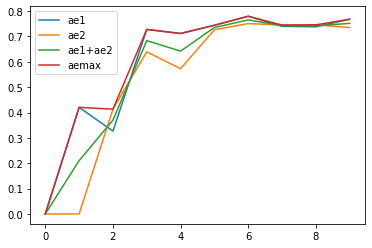

In [113]:
plt.plot(ae1, label='ae1')
plt.plot(ae2, label='ae2')
plt.plot((ae1+ae2)/2, label='ae1+ae2')
plt.plot(aemax, label='aemax')
plt.legend()

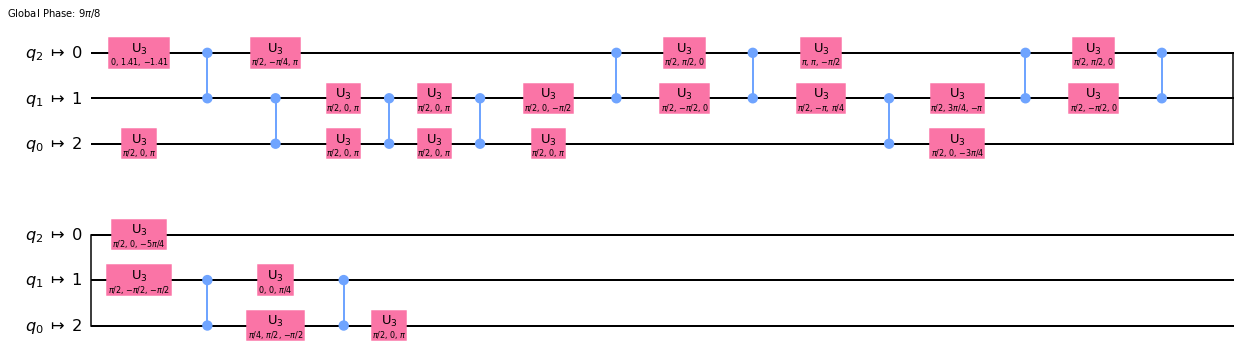

In [149]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc = transpile(qc, basis_gates=['cz', 'u3'], coupling_map=[[0,1], [1,0], [1,2],[2,1]], optimization_level=3)


def partial_toffoli(n):
    toffoli_qasm = qc.qasm()
    return QuantumCircuit.from_qasm_str('\ncz'.join(toffoli_qasm.split('\ncz')[:n]))

qc.draw(output='mpl')

In [167]:
%%time
ae1_list = []
ae2_list = []
for gate_count in range(1, 12):
    u = Operator(partial_toffoli(gate_count).reverse_bits()).data
    u = jnp.array(u)

    _, ae1 = average_entanglement(u, 1, num_samples=500, key=random.PRNGKey(857))
    _, ae2 = average_entanglement(u, 2, num_samples=500, key=random.PRNGKey(192))
    ae1_list.append(ae1)
    ae2_list.append(ae2)
    
ae1 = jnp.array(ae1_list)
ae2 = jnp.array(ae2_list)
aemax = jnp.array([a1 if a1>a2 else a2 for a1,a2 in zip(ae1, ae2)])

CPU times: user 5min 42s, sys: 26.2 s, total: 6min 9s
Wall time: 5min 13s


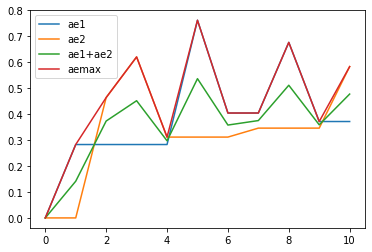

In [168]:
plt.plot(ae1, label='ae1')
plt.plot(ae2, label='ae2')
plt.plot((ae1+ae2)/2, label='ae1+ae2')
plt.plot(aemax, label='aemax')
plt.legend()